In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("../bitcoin_daily.csv")
df

,converted_ts,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,1.325351e+09,4.488000,4.502000,4.488000,4.502000,19.363976,86.439900,4.493282
1,2012-01-01,1.325445e+09,4.920000,4.920000,4.920000,4.920000,10.050000,49.450000,4.920000
2,2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
3,2012-01-03,1.325610e+09,5.216667,5.216667,5.216667,5.216667,10.039698,52.915868,5.216667
4,2012-01-04,1.325695e+09,5.334000,5.355000,5.334000,5.355000,11.511326,61.513860,5.341343
...,...,...,...,...,...,...,...,...,...
3373,2021-03-26,1.616774e+09,53713.961911,53744.860820,53685.498756,53715.866678,3.335749,178897.580671,53714.112556
3374,2021-03-27,1.616861e+09,55368.343291,55394.514668,55343.783361,55370.368281,1.762685,97724.174269,55368.274704
3375,2021-03-28,1.616947e+09,55743.054500,55766.689734,55720.313625,55744.439153,1.387384,77112.419739,55742.179404
3376,2021-03-29,1.617034e+09,57235.672481,57267.246852,57205.425351,57236.598603,3.868826,221942.790902,57234.152701


Text(0, 0.5, 'Close Price (USD)')

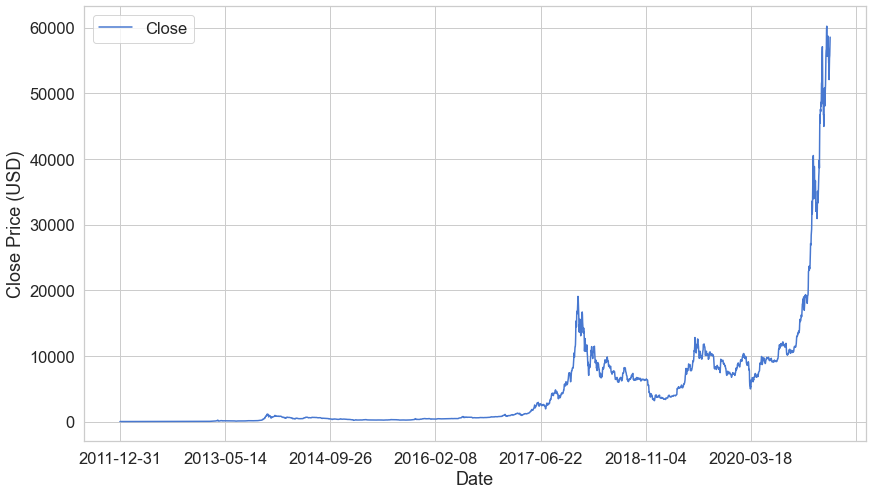

In [5]:
ax = df.plot(x='converted_ts', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Using only closed price

Normalization


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

#scaled_close = scaled_close[~np.isnan(scaled_close)]

scaled_close = scaled_close.reshape(-1, 1)

In [7]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

# Predict the closing price
X_test = torch.tensor(X[-1, :, None], dtype=torch.float32).unsqueeze(0)
y_pred = model(X_test).item()
y_pred = scaler.inverse_transform(np.array([[y_pred]]))

# Using all attributes

In [6]:
class LSTMForecastModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, n_prev):
        super(LSTMForecastModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_prev = n_prev
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)

        # Define the output layer
        self.output_layer = nn.Linear(hidden_size * n_prev, output_size)

    def forward(self, input_seq):
        # Initialize the hidden and cell states
        h0 = torch.zeros(self.n_layers, input_seq.size(0), self.hidden_size).to(input_seq.device)
        c0 = torch.zeros(self.n_layers, input_seq.size(0), self.hidden_size).to(input_seq.device)

        # Feed the input sequence through the LSTM layer
        lstm_output, _ = self.lstm(input_seq, (h0.detach(), c0.detach()))

        # Flatten the LSTM output and pass it through the output layer
        output = self.output_layer(lstm_output.reshape(input_seq.size(0), -1))

        return output

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, n_prev):
        self.n_prev = n_prev
        self.data = data

    def __len__(self):
        return len(self.data) - self.n_prev

    def __getitem__(self, idx):
        idx += self.n_prev
        x = self.data[idx - self.n_prev:idx, :]
        y = self.data[idx, 3] #close
        return x, y

In [ ]:
# Define hyperparameters
input_size = 7
output_size = 1
hidden_size = 128
n_layers = 2
n_prev = 365
batch_size = 64
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# Load the data into a Pandas DataFrame
df_ready = df.drop(columns  = ['converted_ts','Timestamp'])

# Convert the data to a PyTorch tensor and move to device
data_tensor = torch.tensor(df_ready.values, dtype=torch.float).to(device)


# Split the data into training and validation sets
split_idx = int(len(data_tensor) * 0.8)
train_data = data_tensor[:split_idx]
val_data = data_tensor[split_idx:]

# Create the datasets and data loaders
train_dataset = TimeSeriesDataset(train_data, n_prev)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TimeSeriesDataset(val_data, n_prev)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the model and move to device
model = LSTMForecastModel(input_size, output_size, hidden_size, n_layers, n_prev).to(device)

# Create the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


for epoch in range(num_epochs):
    # Train on the training set
    train_loss = 0.0
    model.train()
    for x, y in train_loader:
        # Move data to device
        x = x.to(device)
        y = y.to(device)
        # Zero the gradients, forward pass, backward pass, and update weights
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        train_loss += loss.item()

    # Evaluate on the validation set
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            # Move data to device
            x = x.to(device)
            y = y.to(device)

            # Forward pass and accumulate the loss
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss += loss.item()

    # Print the training and validation loss for the epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss/len(train_loader), val_loss/len(val_loader)))



